In [144]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns

from simulation import *
from aesthetics import *
from plot import * 
prepare_plot()

%reload_ext autoreload
%autoreload 2
%matplotlib inline
mpl.rc('text', usetex=True)
cmap = sns.color_palette("Paired", 10)

# How much power do the dihedral motors generate?

The maximum power generated by each dihedral (at *any* applied load) is stored in a precomputed `pickle` file, so all we have to do is take the sum across substrate concentration.

In [148]:
adk_312 = pd.read_pickle('adk-concentration-scan.pickle')
concentrations = np.unique(adk_312['Concentration'].values)

In [149]:
total_power = np.empty((len(concentrations), 2))
for index, concentration in enumerate(concentrations):
    total_power[index] = (concentration,
             adk_312[np.round(adk_312['Concentration'], 1) == np.round(concentration, 1)]['Max power'].sum())

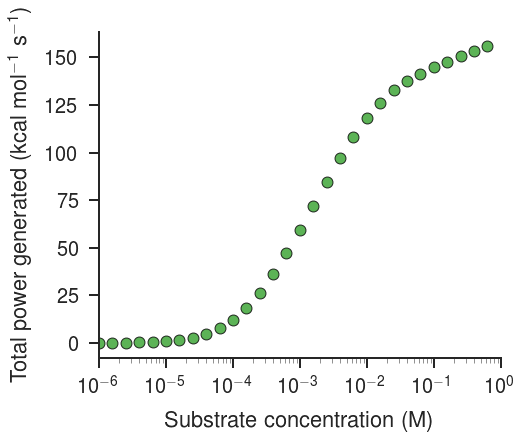

In [150]:
fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1)
ax1 = plt.subplot(grid[0, 0])    
ax1.scatter(10**total_power[::2, 0], total_power[::2, 1], s=120, alpha=0.8, edgecolor='k', lw=1, c=cmap[3])
ax1.set_ylabel('Total power generated (kcal mol$^{-1}$ s$^{-1}$)')
ax1.set_xlabel('Substrate concentration (M)')
ax1.set_xscale('log')
ax1.set_xlim([10**-6, 10**0])
paper_plot(fig)

In [254]:
max_power = np.empty((len(concentrations), 2))
for index, concentration in enumerate(concentrations):
    total_power[index] = (concentration,
             adk_312[np.round(adk_312['Concentration'], 1) == np.round(concentration, 1)]['Max power'].max())

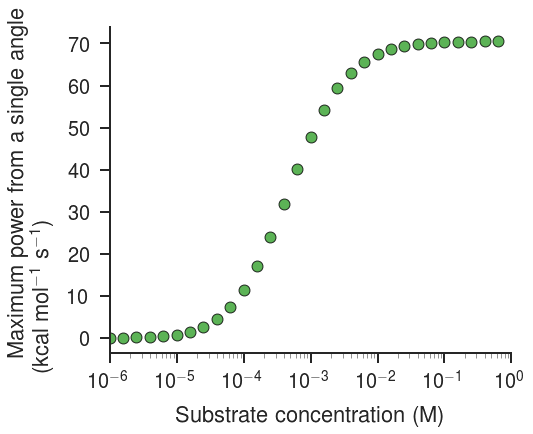

In [259]:
fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1)
ax1 = plt.subplot(grid[0, 0])    
ax1.scatter(10**total_power[::2, 0], total_power[::2, 1], s=120, alpha=0.8, edgecolor='k', lw=1, c=cmap[3])
ax1.set_ylabel(r'Maximum power from a single angle\\(kcal mol$^{-1}$ s$^{-1}$)')
ax1.set_xlabel('Substrate concentration (M)')
ax1.set_xscale('log')
ax1.set_xlim([10**-6, 10**0])
paper_plot(fig)

# What is the enzyme velocity?
The enzyme velocity (or reaction rate) is the catalytic rate (312 s$^{-1}$ for ADK) multiplied by the total population on the bound surface (where catalysis occurs). This is easy enough to compute, so it is not stored. Each torsion will have the same profile, so I picked a common one to make the plot.

In [153]:
velocity = np.empty((len(concentrations), 2))
for index, concentration in enumerate(concentrations):
    this = Simulation(data_source='adk_md_data')
    this.name = 'chi2THR175'
    this.cSubstrate = 10**concentration
    this.simulate()
    velocity[index] = (concentration, this.catalytic_rate * np.sum(this.ss[this.bins:2 * this.bins]))

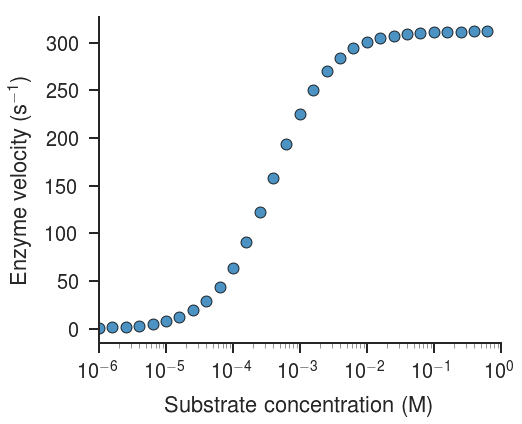

In [154]:
fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1)
ax1 = plt.subplot(grid[0, 0])    
ax1.scatter(10**velocity[::2, 0], velocity[::2, 1], s=120, alpha=0.8, edgecolor='k', lw=1, c=cmap[1])
ax1.set_ylabel('Enzyme velocity (s$^{-1}$)')
ax1.set_xlabel('Substrate concentration (M)')
ax1.set_xlim([10**-6, 10**0])
ax1.set_xscale('log')
paper_plot(fig)

# How much power is going into the system from ATP hydrolysis?
Next, we want to figure out the total input power to the enzyme. The first step is the enzyme velocity (turnover rate). This will ultimately determine how quickly ATP is consumed and the system cycles between apo $\rightarrow$ bound $\rightarrow$ apo. However, we also need to figure out how the much energy is supplied from ATP hydolysis -- and how this changes with concentration.

We assume the concentrations of ADP and inorganic phosphate don't change much and they are (generally) lower than the concentration of ATP. I think what I've done below is sufficiently general that we could also allow the concentration of ADP and ingornic phosphate to float. It turns out that this reaction is also quite sensitive to the concentration (and species) of metal ion, which I have completely ignored here [@Bergman2010].

First, we begin with the fact the physiological reaction free energy ($\Delta_\text{r}G$) for ATP hydolysis is the standard state free energy modified by the physiological concentrations of the reactants and products -- which are *not* close to standard state (1 M).

$$ 
\Delta_\text{r} G = \Delta G^0 + RT \ln \text{adjustment}
$$
where
$$
\text{adjustment} = \frac{[ADP] / (\mathrm{1 M}) \cdot [P_i] / (\mathrm{1 M})}{[ATP] / (\mathrm{1 M})}
$$

The free energy for the reaction at standard state is roughly equal to 30 kJ/mol (7.9 kcal/mol) [@Rosing1972]. The resting concentration of ADP in an E. coli cell is around 1 mM and around 50 mM for inorganic phosphate. In a human cell, curiously, the values are much smaller. [@Wackerhage1998] reports values of [ATP] = 8 mM, [ADP] = 9 uM, [P_i] = 4 mM, and $\Delta_r G$ = -64 kJ/mol (-15.2 kcal/mol) in resting muscle cells.

Bergman, C., Kashiwaya, Y., and Veech, R.L. (2010). The Effect of pH and Free Mg2+ on ATP Linked Enzymes and the Calculation of Gibbs Free Energy of ATP Hydrolysis. J. Phys. Chem. B 114, 16137–16146.

Rosing, J., and Slater, E.C. (1972). The value of ΔG° for the hydrolysis of ATP. Biochimica et Biophysica Acta (BBA) - Bioenergetics 267, 275–290.

Wackerhage, H., Hoffmann, U., Essfeld, D., Leyk, D., Mueller, K., and Zange, J. (1998). Recovery of free ADP, Pi, and free energy of ATP hydrolysis in human skeletal muscle. Journal of Applied Physiology 85, 2140–2145.

In [155]:
deltaG_naught = -7.29                    # kcal/mol  
RT            = 1.9872036 * 10**-3 * 300 # kcal/mol
cADP          = 1.00 * 10**-3            # [M] (E. coli)
cPi           = 50.0 * 10**-3            # [M] (E. coli)

In [156]:
def adjust_reaction(cATP, cADP=1.00*10**-3, cPi=50.0*10**-3):
    return (cADP * cPi) / cATP

def delta_G(deltaG_naught, adjustment):
    deltaG = deltaG_naught + RT * np.log(adjustment)
    print('Delta G = {0:2.1f} kcal/mol = {1:2.1f} kJ/mol = {2:2.1f} kT'.format(deltaG, 4.184*deltaG, 1.688*deltaG))
    return deltaG

In [157]:
delta_G(deltaG_naught, adjust_reaction(cATP=1.0, cADP=1.0, cPi=1.0))

Delta G = -7.3 kcal/mol = -30.5 kJ/mol = -12.3 kT


-7.29

E. coli aerobic exponential growth on glucose...

In [158]:
delta_G(deltaG_naught, adjust_reaction(cATP=1.0*10**-3, cADP=0.6*10**-3, cPi=20.0*10**-3))

Delta G = -9.9 kcal/mol = -41.5 kJ/mol = -16.8 kT


-9.9267302154568959

Homp sapiens resting muscle...

In [160]:
delta_G(deltaG_naught, adjust_reaction(cATP=8.0*10**-3, cADP=9.0*10**-6, cPi=4.0*10**-3))

Delta G = -14.6 kcal/mol = -61.2 kJ/mol = -24.7 kT


-14.629597289721652

In [161]:
deltaG_ATP = np.empty((len(concentrations), 2))
for index, concentration in enumerate(concentrations):
    deltaG_ATP[index] = (concentration, delta_G(deltaG_naught, 
                                                adjust_reaction(
                                                    cATP=10**concentration, cADP=9.0*10**-6, cPi=4.0*10**-3)))

Delta G = -9.3 kcal/mol = -38.8 kJ/mol = -15.7 kT
Delta G = -9.4 kcal/mol = -39.4 kJ/mol = -15.9 kT
Delta G = -9.5 kcal/mol = -39.9 kJ/mol = -16.1 kT
Delta G = -9.7 kcal/mol = -40.5 kJ/mol = -16.3 kT
Delta G = -9.8 kcal/mol = -41.1 kJ/mol = -16.6 kT
Delta G = -10.0 kcal/mol = -41.7 kJ/mol = -16.8 kT
Delta G = -10.1 kcal/mol = -42.2 kJ/mol = -17.0 kT
Delta G = -10.2 kcal/mol = -42.8 kJ/mol = -17.3 kT
Delta G = -10.4 kcal/mol = -43.4 kJ/mol = -17.5 kT
Delta G = -10.5 kcal/mol = -44.0 kJ/mol = -17.7 kT
Delta G = -10.6 kcal/mol = -44.5 kJ/mol = -18.0 kT
Delta G = -10.8 kcal/mol = -45.1 kJ/mol = -18.2 kT
Delta G = -10.9 kcal/mol = -45.7 kJ/mol = -18.4 kT
Delta G = -11.1 kcal/mol = -46.3 kJ/mol = -18.7 kT
Delta G = -11.2 kcal/mol = -46.8 kJ/mol = -18.9 kT
Delta G = -11.3 kcal/mol = -47.4 kJ/mol = -19.1 kT
Delta G = -11.5 kcal/mol = -48.0 kJ/mol = -19.4 kT
Delta G = -11.6 kcal/mol = -48.6 kJ/mol = -19.6 kT
Delta G = -11.7 kcal/mol = -49.1 kJ/mol = -19.8 kT
Delta G = -11.9 kcal/mol = -49.7 kJ/

Given a fixed concentration of products (ADP and inorganic phosphate) the free energy goes up linearly as ATP concenctration increases!

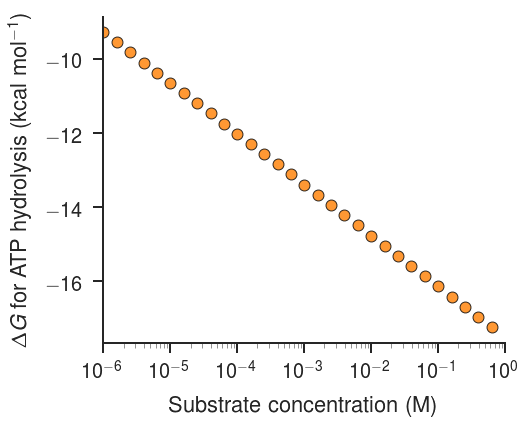

In [165]:
fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1)
ax1 = plt.subplot(grid[0, 0])    
ax1.scatter(10**deltaG_ATP[::2, 0], deltaG_ATP[::2, 1], s=120, alpha=0.8, edgecolor='k', lw=1, c=cmap[7])
ax1.set_ylabel(r'$\Delta G$ for ATP hydrolysis (kcal mol$^{-1}$)')
ax1.set_xlabel('Substrate concentration (M)')
ax1.set_xlim([10**-6, 10**0])
ax1.set_xscale('log')
paper_plot(fig)

Now, we can calculate the power input to the enzyme:
$$
\text{Power ([S])} = \text{Enzyme velocity ([S])} \times \Delta G ([S]) 
$$

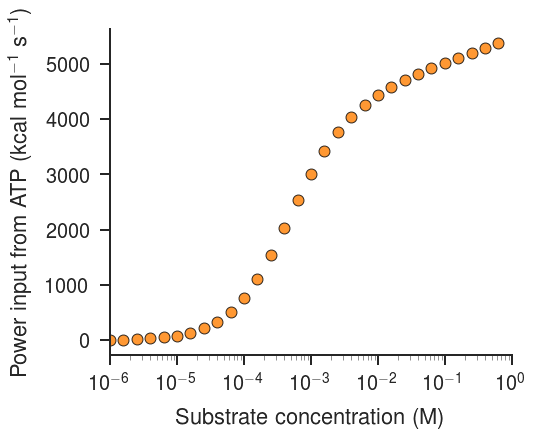

In [167]:
fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1)
ax1 = plt.subplot(grid[0, 0])    
ax1.scatter(10**deltaG_ATP[::2, 0], -deltaG_ATP[::2, 1] * velocity[::2, 1], s=120, alpha=0.8, edgecolor='k', lw=1, c=cmap[7])
ax1.set_ylabel(r'Power input from ATP  (kcal mol$^{-1}$ s$^{-1}$)')
ax1.set_xlabel('Substrate concentration (M)')
ax1.set_xlim([10**-6, 10**0])
ax1.set_xscale('log')
paper_plot(fig)

# What is the efficiency of the torsion motors?

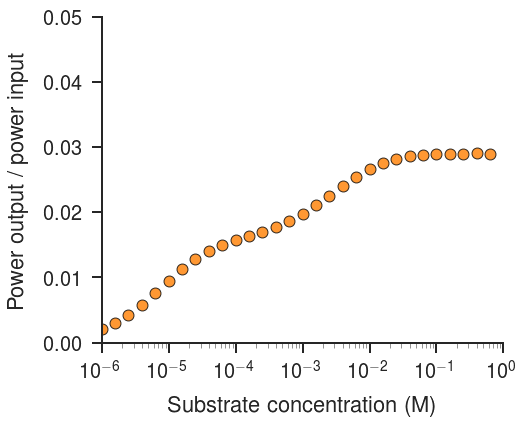

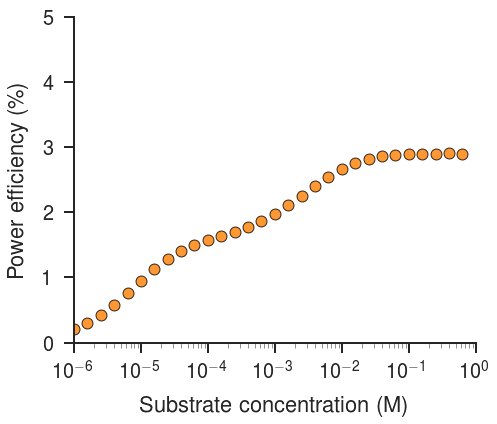

In [169]:
fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1)
ax1 = plt.subplot(grid[0, 0])    
ax1.scatter(10**deltaG_ATP[::2, 0], total_power[::2, 1] / (-deltaG_ATP[::2, 1] * velocity[::2, 1]), 
            s=120, alpha=0.8, edgecolor='k', lw=1, c=cmap[7])
ax1.set_ylabel(r'Power output / power input')
ax1.set_xlabel('Substrate concentration (M)')
ax1.set_xlim([10**-6, 10**0])
ax1.set_ylim([0.00, 0.05])
ax1.set_xscale('log')
paper_plot(fig)

fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1)
ax1 = plt.subplot(grid[0, 0])    
ax1.scatter(10**deltaG_ATP[::2, 0], 100 * total_power[::2, 1] / (-deltaG_ATP[::2, 1] * velocity[::2, 1]), 
            s=120, alpha=0.8, edgecolor='k', lw=1, c=cmap[7])
ax1.set_ylabel(r'Power efficiency (\%)')
ax1.set_xlabel('Substrate concentration (M)')
ax1.set_xlim([10**-6, 10**0])
ax1.set_ylim([0.00, 5])
ax1.set_xscale('log')
paper_plot(fig)

# Where does the power go?

Assuming Stokes' drag, we can calculate the drag force that opposes motion by an object or radius $r$ (around 5 nm) through fluid with dynamic viscosity $\eta$ (around $10^{-3}$ Pa $\cdot$ s), given some velocity:
$$
\mathbf{F}_\text{drag} = -6 \pi \eta r \mathbf{v}
$$

If a small sphere of radius 0.5 uM is moving with a velocity of 10 uM/second, then the drag force will be 0.09 pN. This roughly corresponds to the forces on a bacterium swimming through water. For comparison, the stall force on a typical motor myosin is 3-4 pN and takes steps of roughly 10 nM, thus doing work on the order of 40 pN $\cdot$ nm from 1 ATP molecule.

Likewise, power is work per unit time, which is equivalent to force multiplied by distance per unit time, or force times velocity. Thus, given a power input, we can calculate the velocity if all the power goes into hydrodynamic drag at low Reynolds number:

$$
P = \mathbf{F}_\text{drag} \cdot \mathbf{v} = 6 \pi \eta r v^2\\
v = \sqrt{\frac{P}{6 \pi \eta r}}
$$


In [208]:
def force_from_velocity(v, r=5*10**-9, eta=1*10**-3):
    return 6 * np.pi * eta * r * v

In [209]:
def velocity_from_power(p, r=5*10**-9, eta=1*10**-3):
    p_J_per_molecule = p * (6.94 * 10**-21)
    return np.sqrt(p_J_per_molecule / (6 * np.pi * eta * r))

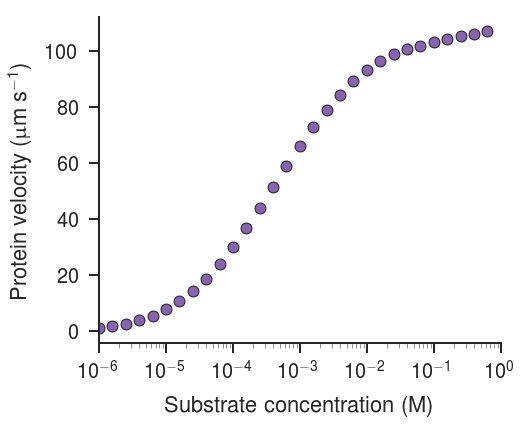

In [212]:
fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1)
ax1 = plt.subplot(grid[0, 0])    
ax1.scatter(10**total_power[::2, 0], 10**6*velocity_from_power(total_power[::2, 1]), 
            s=120, alpha=0.8, edgecolor='k', lw=1, c=cmap[9])
ax1.set_ylabel(r'Protein velocity ($\mu$m s$^{-1}$)')
ax1.set_xlabel('Substrate concentration (M)')
ax1.set_xlim([10**-6, 10**0])
ax1.set_xscale('log')
paper_plot(fig)

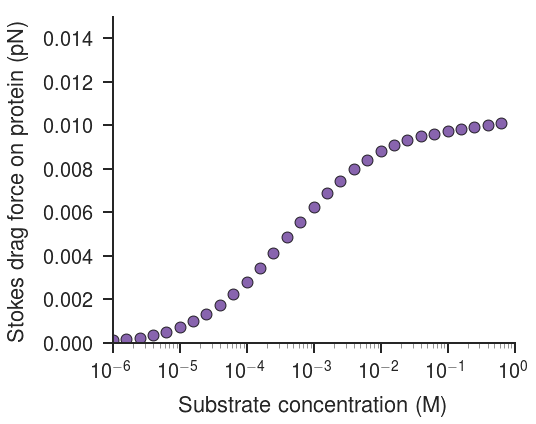

In [229]:
fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1)
ax1 = plt.subplot(grid[0, 0])    
ax1.scatter(10**total_power[::2, 0], 10**12*force_from_velocity(velocity_from_power(total_power[::2, 1])), 
            s=120, alpha=0.8, edgecolor='k', lw=1, c=cmap[9])
ax1.set_ylabel(r'Stokes drag force on protein (pN)')
ax1.set_xlabel('Substrate concentration (M)')
ax1.set_xlim([10**-6, 10**0])
ax1.set_ylim([0, 0.015])
ax1.set_xscale('log')
paper_plot(fig)

# Do these forces enhance diffusion?

According to Mudong, we can arrive at the equation:

$$
R = \frac{D - D_0}{D_0} = \frac{F^2 t}{36 \pi \eta kT r}
$$
where $D$ is the diffusion coefficient with force $F$, $D_0$ is the unperturbed diffusion coefficient, and $t$ is the time over which these forces act.

In [235]:
def diffusion_enhancement(F, t=1*10**-9, r=5*10**-9, eta=1*10**-3, kT=4.11*10**-21):
    R = (F**2 * t) / (36 * np.pi * eta * kT * r)
    return R

First let's check to confirm what Mudong reports: a force of 60 pN is required to enhance diffusion by 50%. 

In [253]:
diffusion_enhancement(60 * 10**-12)

1.5489532174393708

We have forces about 100 fold below pN, so I expect diffusion to be enhanced much less than 50%.

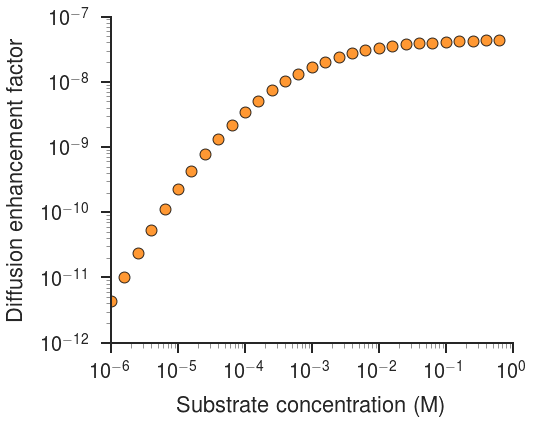

In [252]:
fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1)
ax1 = plt.subplot(grid[0, 0])    
ax1.scatter(10**total_power[::2, 0], diffusion_enhancement(force_from_velocity(velocity_from_power(total_power[::2, 1]))), 
            s=120, alpha=0.8, edgecolor='k', lw=1, c=cmap[7])
ax1.set_ylabel(r'Diffusion enhancement factor')
ax1.set_xlabel('Substrate concentration (M)')
ax1.set_xlim([10**-6, 10**0])
ax1.set_ylim([10**-12, 10**-7])
ax1.set_yscale('log')
ax1.set_xscale('log')
paper_plot(fig)